In [2]:
import pandas as pd, time, re, sqlite3, matplotlib.pyplot as plt, numpy as npy
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from sklearn.linear_model import LinearRegression


options = webdriver.ChromeOptions()
options.add_experimental_option("detach",True)
service=ChromeService(ChromeDriverManager().install()) # instead of pointing to a specific path -> just install the service to use it

[WDM] - Downloading: 100%|██████████| 6.80M/6.80M [00:00<00:00, 18.1MB/s]


In [3]:
driver = webdriver.Chrome(service=service,options=options)

sqliteconnection = sqlite3.connect('MSIS615GroupProjectDB')
cursor = sqliteconnection.cursor()

company_list = ['MSFT','AAPL','AMZN','GOOGL','META','TSLA','NFLX','NVDA','BABA','CRM','AMD','INTC'] # list of tickers, update as needed

regexth = re.compile(r'<th class=.*?><span>(.*?)</span></th>',re.S|re.I) # regular expression for table headers.
regextd = re.compile(r'<td class=.*?><span>(.*?)</span></td>',re.S|re.I) # regular expression to identify table data.
table_data_pattern = re.compile(r'... \d\d, \d\d\d\d',re.S|re.I) # regular expression to help group data into lists.

df = pd.DataFrame()

def scroll_bot(SCROLL_PAUSE_TIME=0.5): # scrolling function, default time is 0.5s
    last_height = driver.execute_script("return document.documentElement.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
        time.sleep(SCROLL_PAUSE_TIME)
        new_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

def group_list(data_list,table_data_pattern,company_name): # function to group data into lists, with a final product being a list of all the lists
    result = [] # finalize grouping of data points
    for el in data_list:
        if table_data_pattern.match(el):
            row = []
            result.append(row)
            row.append(company_name)
        row.append(el)
    mylist = [c for c in result if len(c)>2 and len(c)<9]
    return mylist
        
for company_name in company_list:
    driver.get(f'https://finance.yahoo.com/quote/{company_name}/history?period1=1524182400&period2=1681948800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true')
    time.sleep(3)
    
    scroll_bot()
    
    get_table = driver.find_element(By.XPATH,'//table[@data-test="historical-prices"]') # Pull the specific table data -> reduce size for processing
    table_source = get_table.get_attribute('innerHTML') # process web element into html
    
    data_list = regextd.findall(table_source)
    temp_list = group_list(data_list,table_data_pattern,company_name) 
    temp_df = pd.DataFrame(temp_list) # create a temp dataframe to concat to existing dataframe
    df = pd.concat([df,temp_df])

header_list=['Company'] + regexth.findall(table_source) # create a list that includes all headers within the table and 'company' column for differentiating companies.
df.columns = header_list
df['Date'] = pd.to_datetime(df['Date']).dt.date # convert dates to proper data type.

driver.close()

df.to_sql(name='Tech_Stock_History',con=sqliteconnection,if_exists='replace',index=False) # Create table, if exists, replaces with same name table - uses dataframe data - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html
query_data = pd.read_sql('Select * From Tech_Stock_History', sqliteconnection) # Create second dataframe for querying/not accidentally overwrite the first dataframe

display(query_data) # This is for viewing the data that was inserted to sqlite3 db to confirm it was successful
# print(query_data) # display is a function unique to jupyter notebook and jupyter extensions.

sqliteconnection.commit()
sqliteconnection.close() # CLOSE CONNECTION AS NOT NEEDED ANYMORE

,Company,Date,Open,High,Low,Close*,Adj Close**,Volume
0,MSFT,2023-04-19,285.99,289.05,284.54,288.45,288.45,"17,150,300"
1,MSFT,2023-04-18,291.57,291.76,287.01,288.37,288.37,"20,161,800"
2,MSFT,2023-04-17,289.93,291.60,286.16,288.80,288.80,"23,836,200"
3,MSFT,2023-04-14,287.00,288.48,283.69,286.14,286.14,"20,973,900"
4,MSFT,2023-04-13,283.59,289.90,283.17,289.84,289.84,"24,222,700"
...,...,...,...,...,...,...,...,...
15079,INTC,2018-04-27,55.44,55.79,52.23,52.73,45.48,"69,888,100"
15080,INTC,2018-04-26,52.26,53.27,52.07,53.05,45.75,"39,575,000"
15081,INTC,2018-04-25,51.86,52.10,50.60,51.38,44.31,"25,752,800"
15082,INTC,2018-04-24,51.87,53.64,51.14,51.45,44.37,"42,494,700"


C:\Users\Steven Tung\AppData\Local\Temp\ipykernel_27308\2531121147.py:7: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  grouped_data = query_data.groupby(['Company','Date']).mean()['Adj Close**'].reset_index()


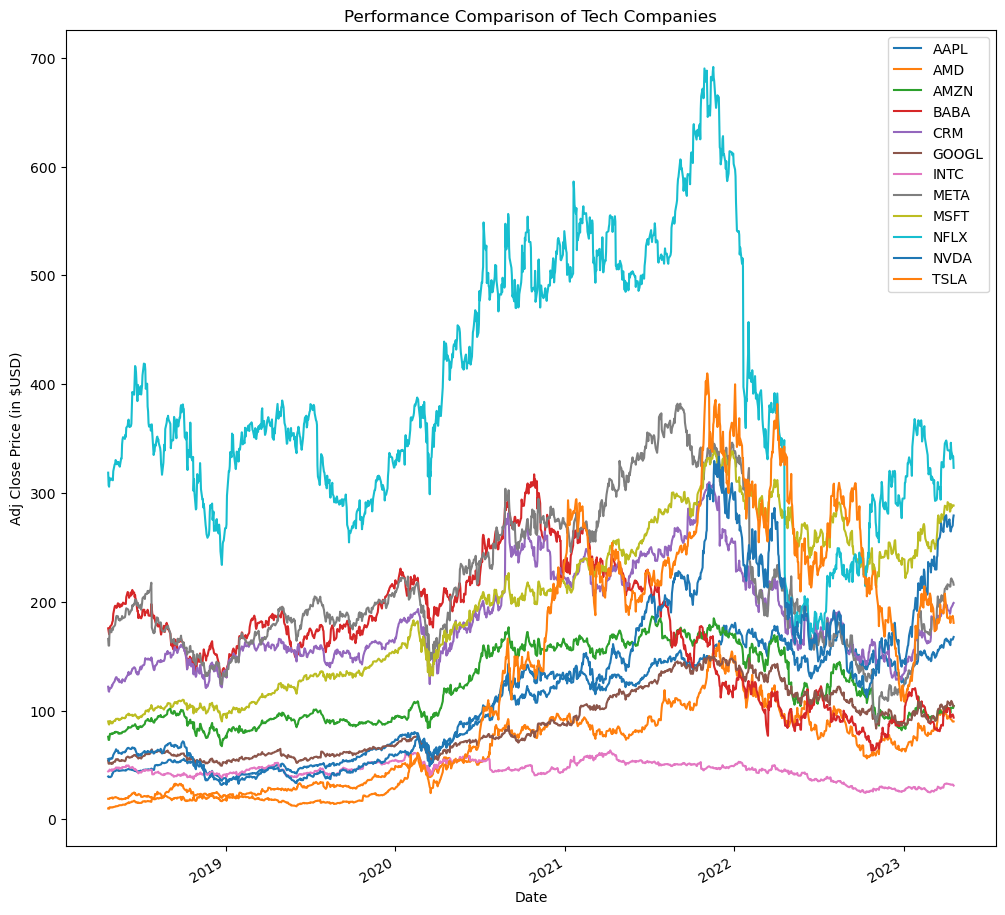

In [4]:
faang = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
query_data['Date'] = pd.to_datetime(query_data['Date'])

plt.rcParams['figure.figsize'] = [12,12] # Resize plot to make it more easier to see.

# Group data by Company and Date, and calculate average Adj Close for each group
grouped_data = query_data.groupby(['Company','Date']).mean()['Adj Close**'].reset_index()

# Pivot the table to have Company as columns and Date as index
pivot_data = grouped_data.pivot(index='Date',columns='Company',values='Adj Close**')

# Plot the closing price for each company over time
pivot_data.plot()

# Set up legend and graph.
plt.legend()
plt.xlabel('Date')
plt.ylabel('Adj Close Price (in $USD)')
plt.title('Performance Comparison of Tech Companies')
plt.show() 

C:\Users\Steven Tung\AppData\Local\Temp\ipykernel_27308\2976677426.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  faang_data = faang_data.groupby(['Company', 'Date']).mean()['Adj Close**'].reset_index()


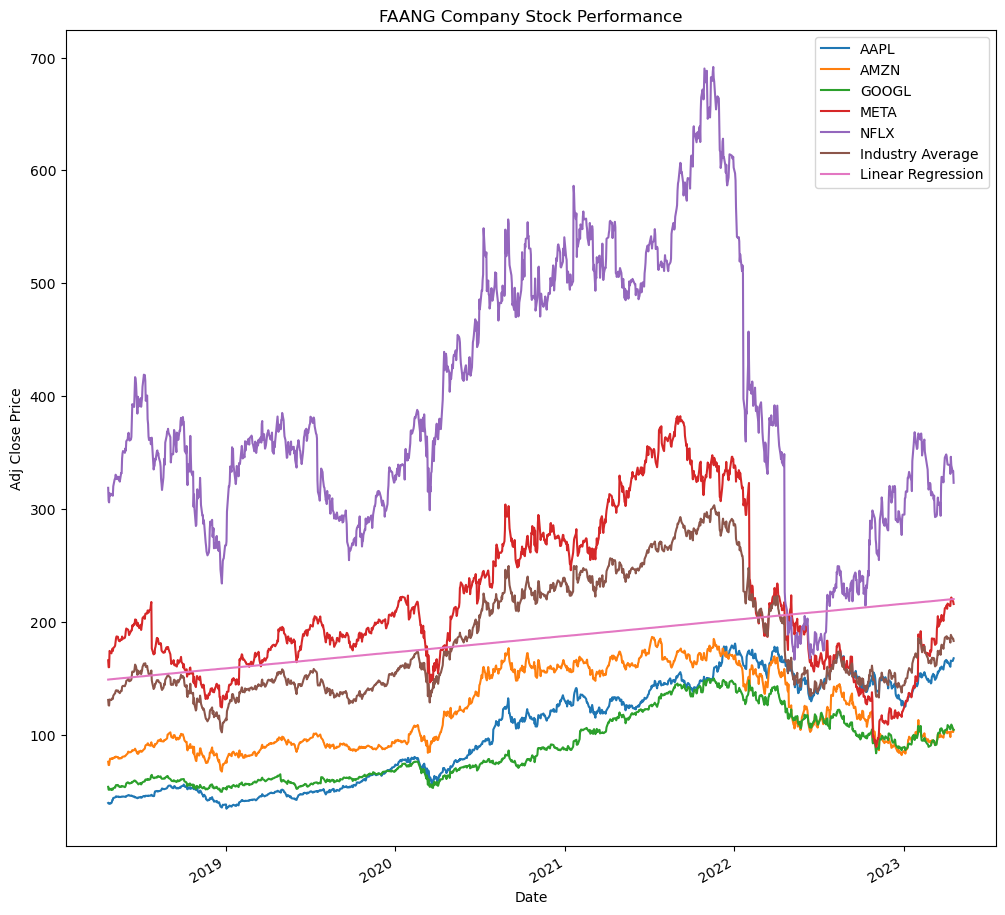

In [5]:
# Keep only data for FAANG companies
faang_data = query_data[query_data['Company'].isin(faang)]

# Convert Date column to datetime format
#faang_data['Date'] = pd.to_datetime(faang_data['Date'])

# Group data by Company and Date, and calculate average Adj Close for each group
faang_data = faang_data.groupby(['Company', 'Date']).mean()['Adj Close**'].reset_index()

# Pivot the table to have Company as columns and Date as index
faang_data = faang_data.pivot(index='Date', columns='Company', values='Adj Close**')

# Plot the closing price for each company over time
faang_data.plot()

# Calculate the average closing price over time
average_faang_data = faang_data.mean(axis=1)

# Plot the average closing price over time
average_faang_data.plot(label='Industry Average')

# Find the minimum and maximum dates in the data
min_date = faang_data.index.min()
max_date = faang_data.index.max()

# Create a range of dates to use for the regression line
reg_dates = pd.date_range(start=min_date, end=max_date, freq='D')
reg_dates = reg_dates[reg_dates.isin(faang_data.index)]

# Fit a linear regression line to the average closing price using the new dates
X_reg = pd.DataFrame({'x': range(len(reg_dates))}, index=reg_dates)
Y_reg = average_faang_data.values.reshape(-1, 1)
reg = LinearRegression().fit(X_reg, Y_reg)
y_pred = reg.predict(X_reg)
plt.plot(X_reg.index, y_pred, label='Linear Regression')


# Add legend and labels to the graph
plt.legend()
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('FAANG Company Stock Performance')

# Show the graph
plt.show()

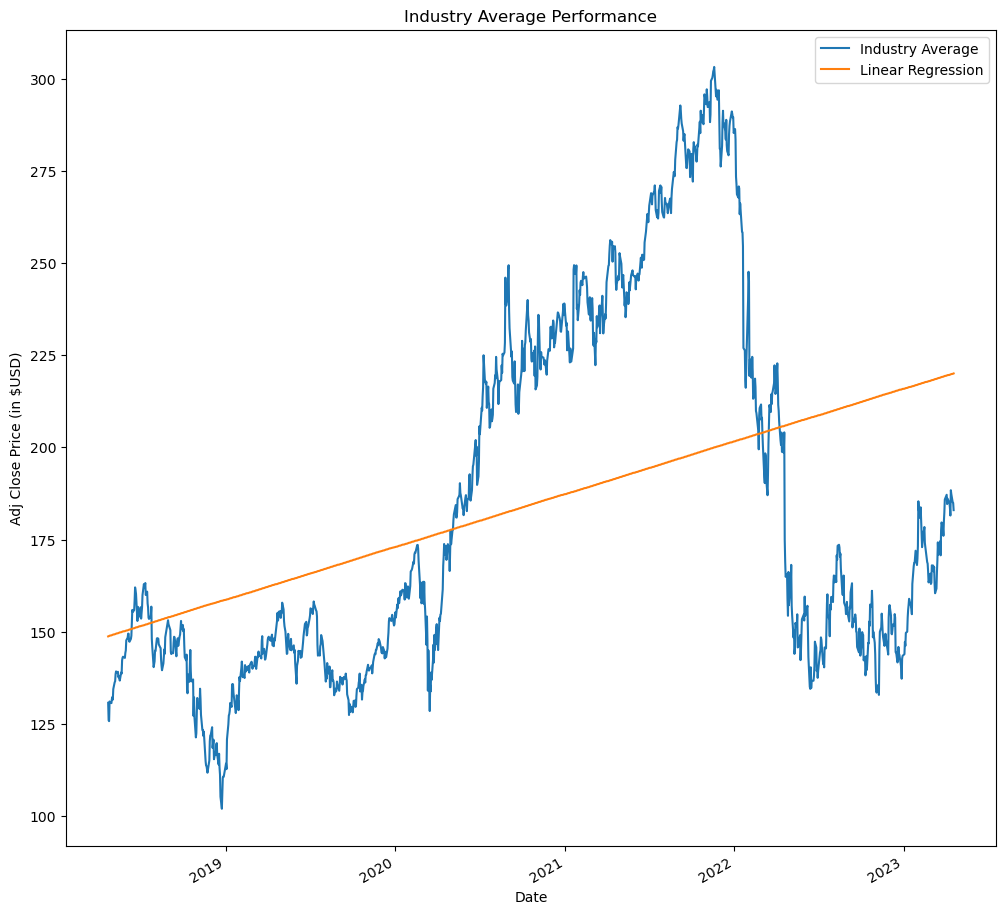

In [6]:
# Plot the average closing price over time
average_faang_data.plot(label='Industry Average')
plt.plot(X_reg.index, y_pred, label='Linear Regression')

# plot formatting
plt.legend()
plt.xlabel('Date')
plt.ylabel('Adj Close Price (in $USD)')
plt.title('Industry Average Performance')
plt.show() 

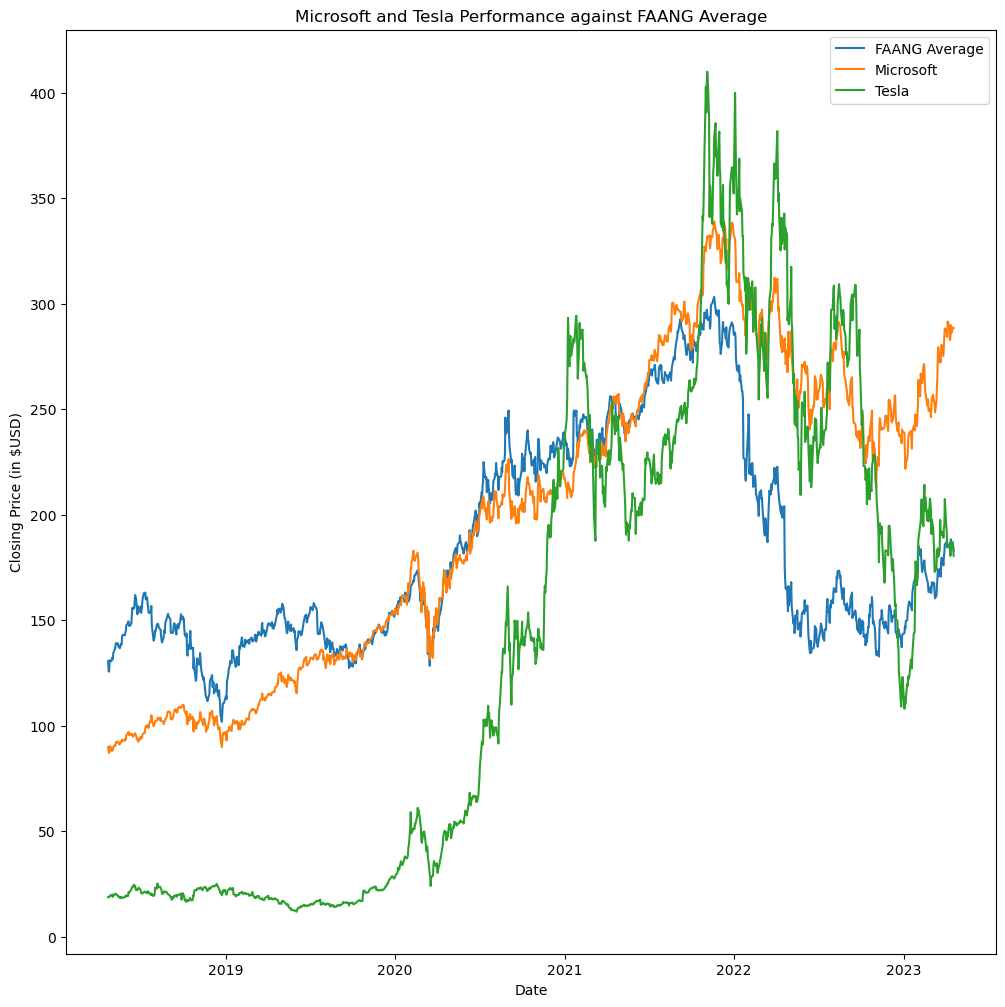

In [7]:

faang_average = faang_data.mean(axis=1)
msft_data = pivot_data['MSFT']
tsla_data = pivot_data['TSLA']

plt.plot(faang_average.index, faang_average, label='FAANG Average')
plt.plot(msft_data.index, msft_data, label='Microsoft')
plt.plot(tsla_data.index, tsla_data, label='Tesla')

# plot formatting
plt.legend()
plt.title('Microsoft and Tesla Performance against FAANG Average')
plt.xlabel('Date')
plt.ylabel('Closing Price (in $USD)')
plt.show()

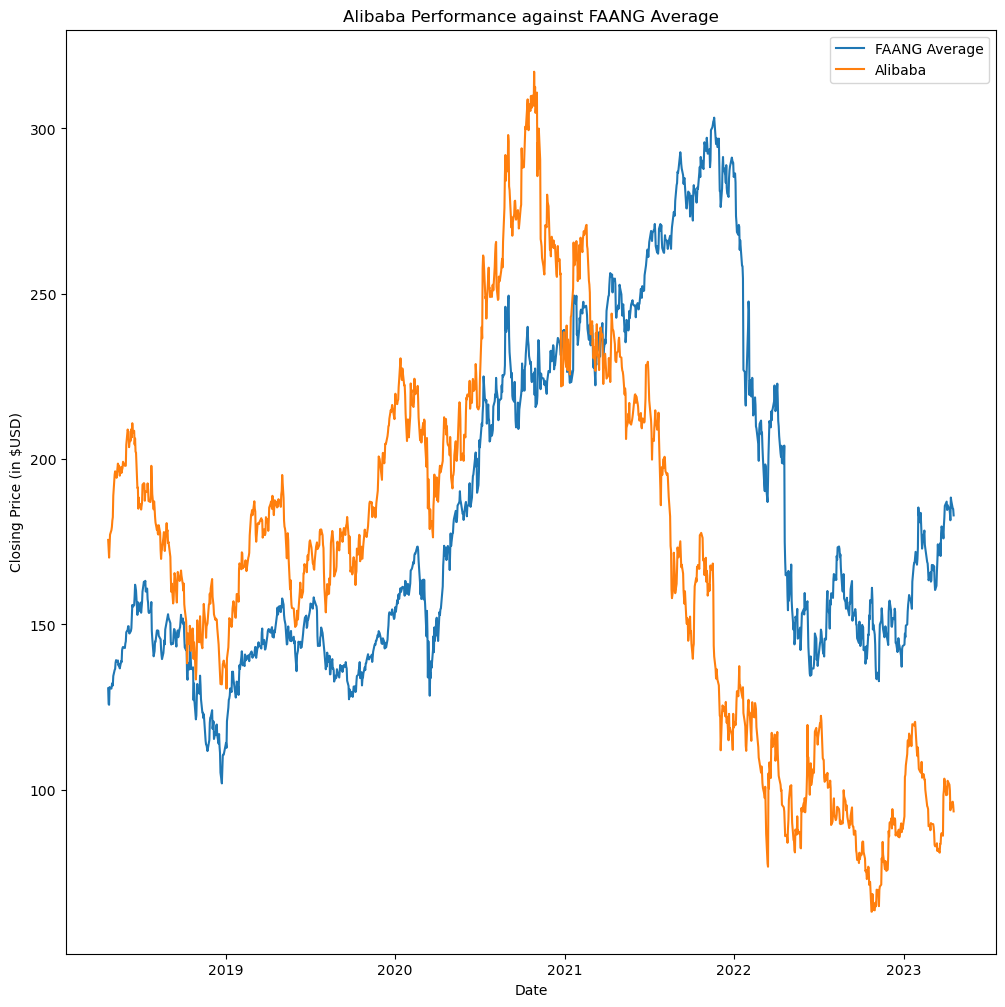

In [8]:
faang_average = faang_data.mean(axis=1)
baba_data = pivot_data['BABA']

plt.plot(faang_average.index, faang_average, label='FAANG Average')
plt.plot(baba_data.index, baba_data, label='Alibaba')

# plot formatting
plt.legend()
plt.title('Alibaba Performance against FAANG Average')
plt.xlabel('Date')
plt.ylabel('Closing Price (in $USD)')
plt.show()

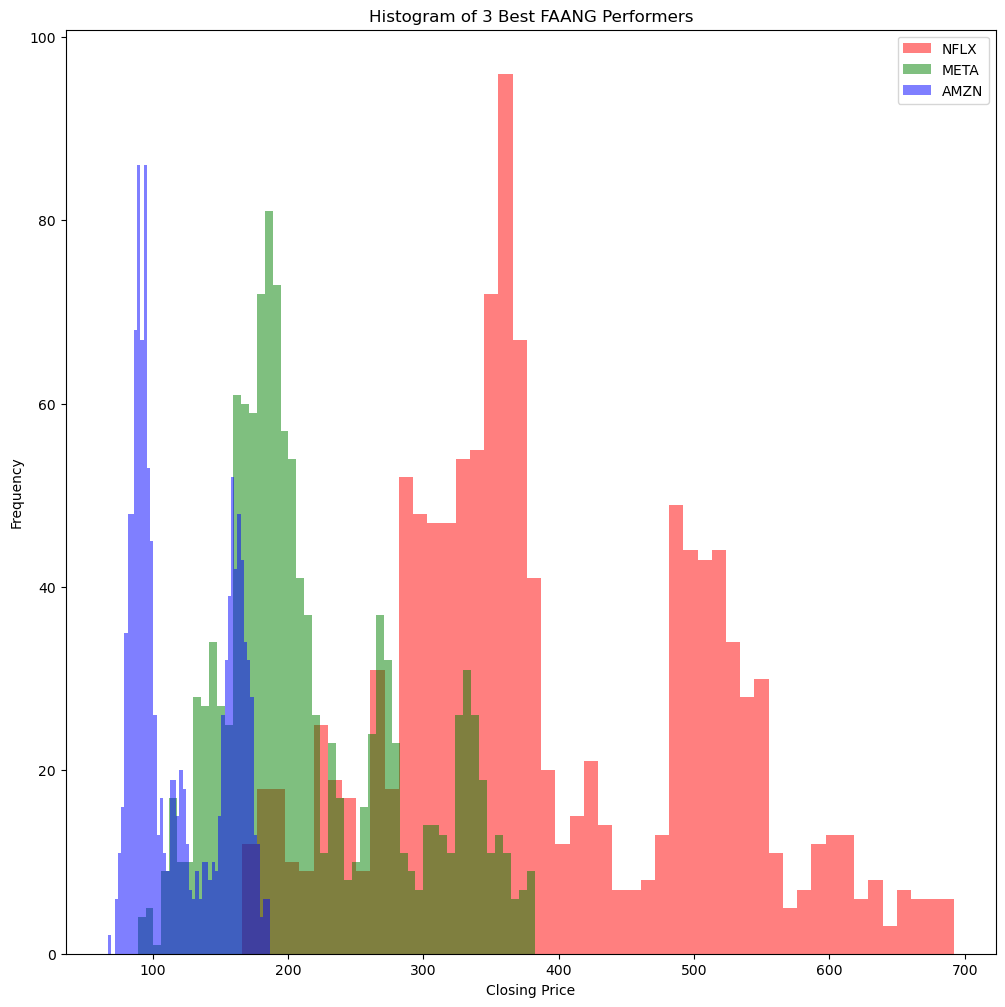

In [9]:
# Calculate the average closing price for each stock
avg_data = faang_data.mean()
#print(avg_data)
# Sort the stocks based on the average closing price
sorted_data = avg_data.sort_values(ascending=False)
#print(sorted_data)
# Get the top 3 performers
top_performers = sorted_data[:3].index.tolist()

# Plot a histogram of the closing prices for each stock
colors = ['red', 'green', 'blue']
for i, stock in enumerate(top_performers):
    plt.hist(faang_data[stock], bins=50, alpha=0.5, color=colors[i], label=stock)

# plot formatting
plt.legend()
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.title('Histogram of 3 Best FAANG Performers')
plt.show()

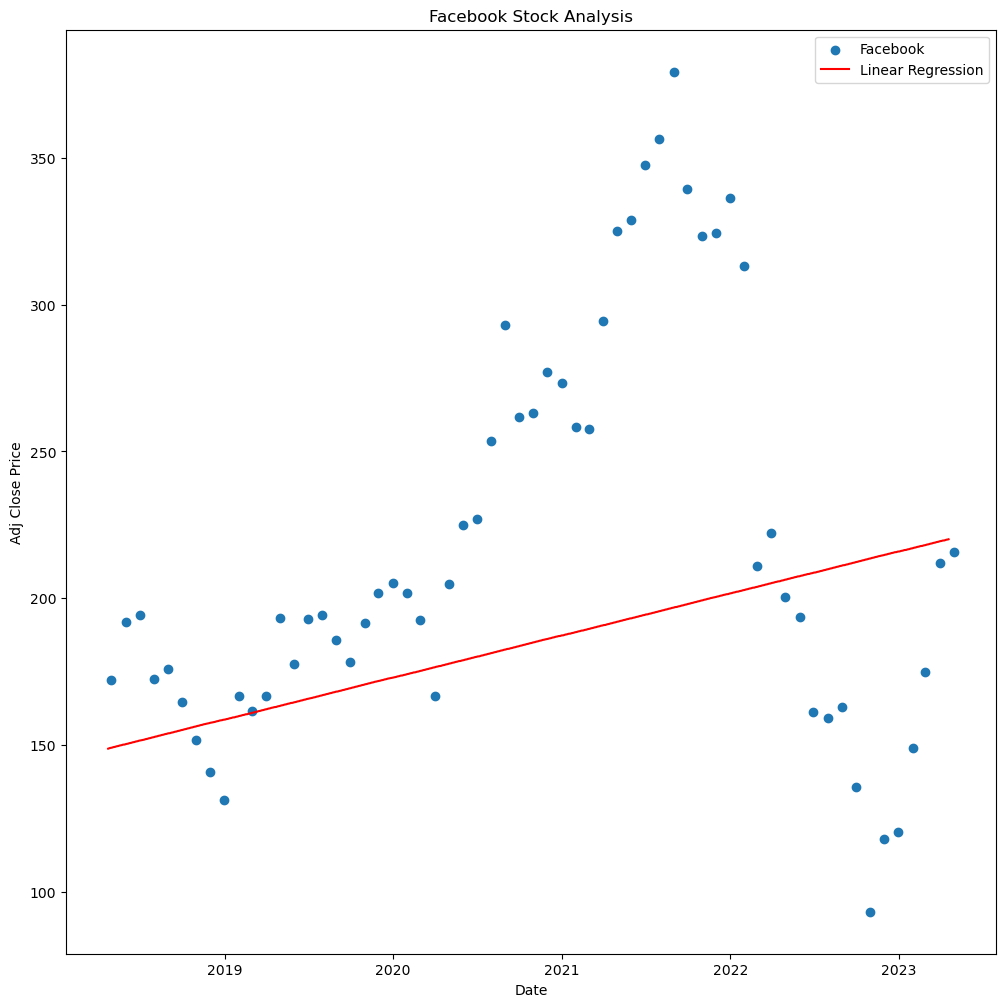

In [10]:
meta_data = faang_data['META'].resample('m').last()

plt.scatter(meta_data.index, meta_data, label='Facebook')

plt.plot(X_reg.index, y_pred, label='Linear Regression',c ='red')

# Add legend and labels to the graph
plt.legend()
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('Facebook Stock Analysis')

# Show the graph
plt.show()